In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from langdetect import detect # language detection
import numpy as np # linear algebra
import tqdm # progress bar
import re # regular expressions
import pickle as pkl # saving and loading pythonic data

## Import custom libraries

In [3]:
import sys, os # system specific parameters and functions
sys.path.append(os.getcwd() + "/../") # add parent directory to path
from src.data_preprocessing import DataPreprocessing

## Load the data

In [4]:
dp = DataPreprocessing(df_path="../data/real_estate_ads_2022_10.csv", 
                       train_indices_path="../data/train_indices.npy", 
                       test_indices_path="../data/test_indices.npy")

In [6]:
dp.X.columns

Index(['market', 'created_at_first', 'updated_at', 'district_lon',
       'district_lat', 'title', 'description', 'params', 'no_rooms', 'm',
       'map_lon', 'map_lat'],
      dtype='object')

## Get the time features

The time features are "created_at_first" and "updated_at"

In [9]:
time_features = dp.X[['created_at_first', 'updated_at']]
time_features

,created_at_first,updated_at
0,2019-04-09 16:12:54.000,2019-04-15 18:54:38.000
1,2019-04-25 17:20:01.000,2019-05-27 11:36:14.000
2,2018-08-02 16:40:35.000,2021-11-28 01:56:53.000
3,2019-12-05 12:45:49.000,2020-01-15 16:05:42.000
4,2020-01-10 14:53:19.000,2020-02-13 15:25:07.000
...,...,...
73640,2019-07-16 22:38:08.000,2019-10-14 23:01:42.000
73641,2019-07-17 11:18:30.000,2019-08-07 14:22:54.000
73642,2019-07-16 13:40:35.000,2019-07-23 00:30:42.000
73643,2019-07-03 20:50:27.000,2022-06-17 17:14:34.000


### Convert to datetime

In [11]:
time_features.loc[:,"created_at_first"] = pd.to_datetime(time_features["created_at_first"])
time_features.loc[:,"updated_at"] = pd.to_datetime(time_features["updated_at"])

## Extract components
Datetime could be use as a numerical feature by simply taking an absolute variable.

However, it may be more useful to get features such as year / month / hour, since these features correlate with human behaviours (holidays, sleeping times, work times, ...).

In [14]:
df = time_features # this is just to make the code more readable

df.loc[:,'created_year'] = df['created_at_first'].dt.year
df.loc[:,'created_month'] = df['created_at_first'].dt.month
df.loc[:,'created_day'] = df['created_at_first'].dt.day
df.loc[:,'created_hour'] = df['created_at_first'].dt.hour
df.loc[:,'created_dayofweek'] = df['created_at_first'].dt.dayofweek
df.loc[:,'created_is_weekend'] = df['created_dayofweek'] >= 5

### Plot wrt the target variable
This could help see which of these variables could be more useful

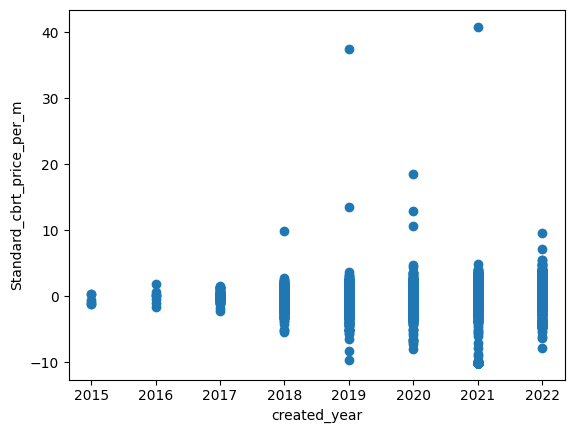

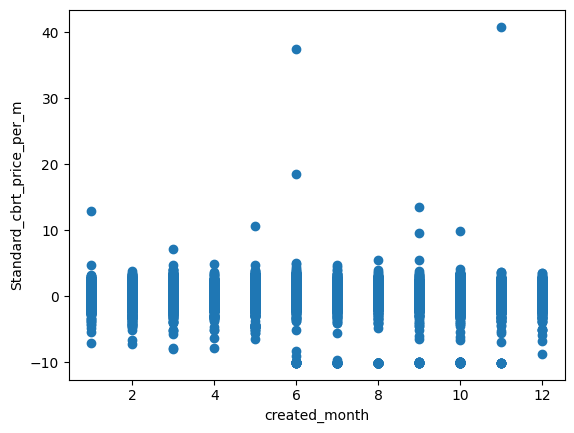

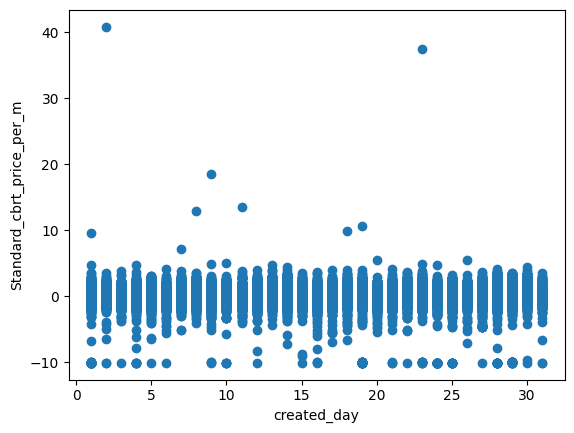

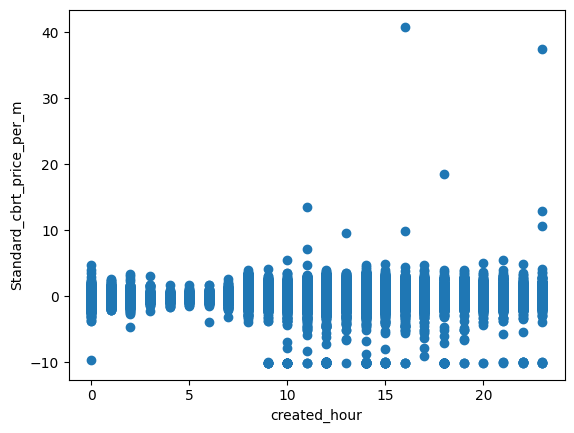

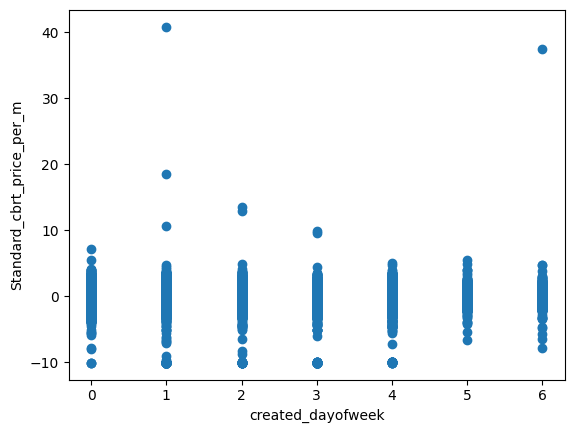

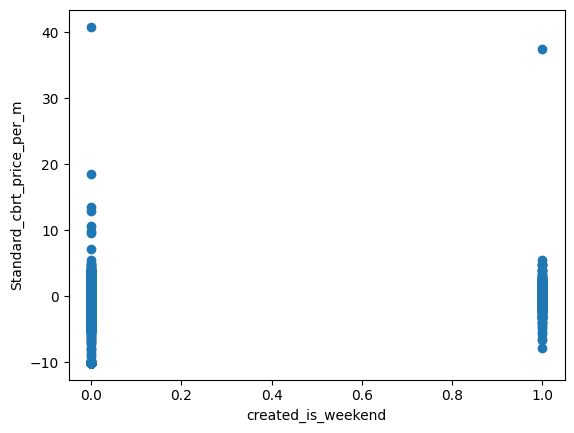

In [19]:
import matplotlib.pyplot as plt
def plot_wrt_Y(column_name):
    plt.scatter(df[column_name], dp.Y)
    plt.xlabel(column_name)
    plt.ylabel("Standard_cbrt_price_per_m")
    plt.show()

for column_name in df.columns[2:]:
    plot_wrt_Y(column_name)

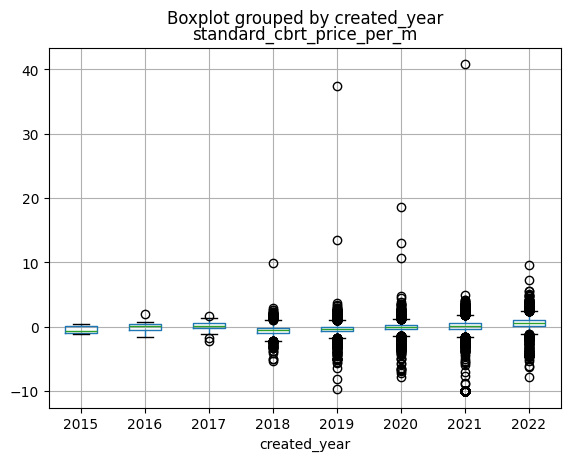

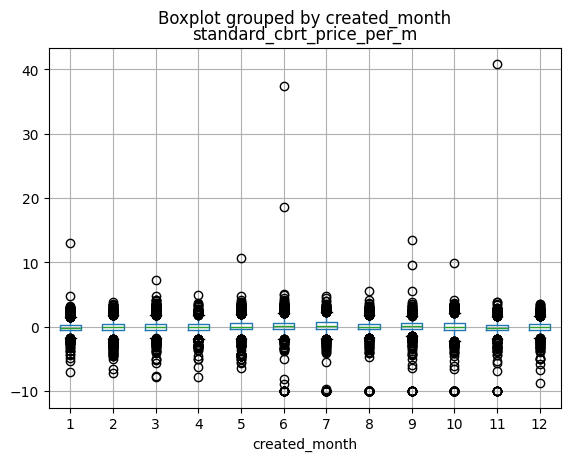

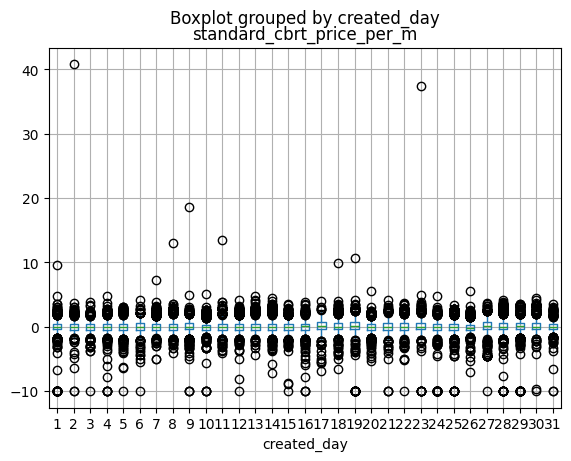

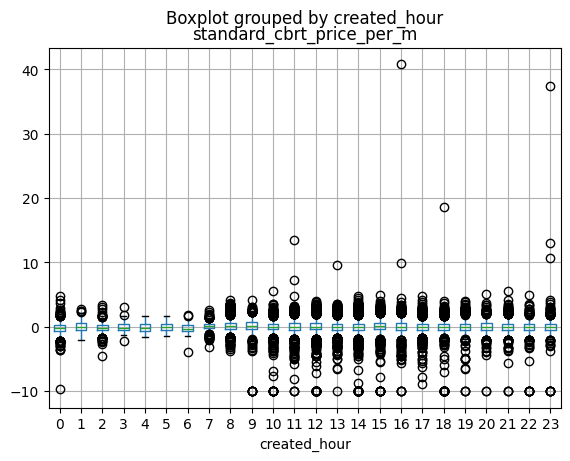

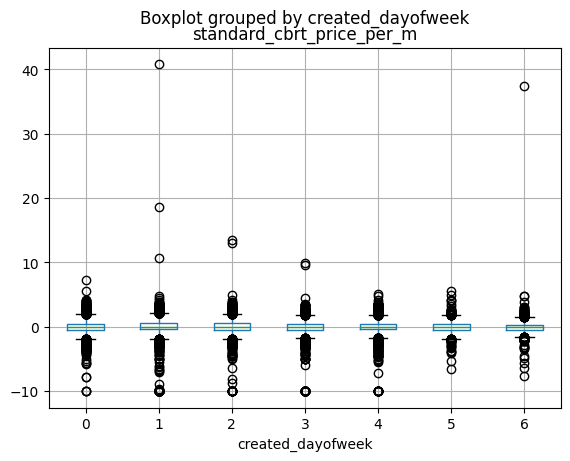

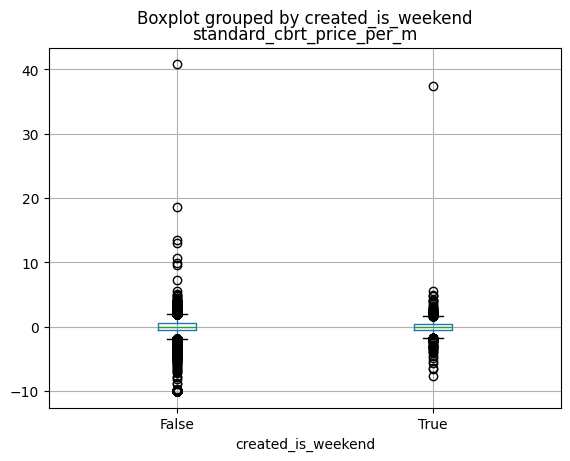

In [28]:
def boxplots_wrt_Y(column_name):
    pd.concat([df,dp.Y], axis=1).boxplot(column="standard_cbrt_price_per_m", by=column_name)
for column_name in df.columns[2:]:
    boxplots_wrt_Y(column_name)

## We can repeat for updated values

In [30]:
df.loc[:,'updated_year'] = df['updated_at'].dt.year
df.loc[:,'updated_month'] = df['updated_at'].dt.month
df.loc[:,'updated_day'] = df['updated_at'].dt.day
df.loc[:,'updated_hour'] = df['updated_at'].dt.hour
df.loc[:,'updated_dayofweek'] = df['updated_at'].dt.dayofweek
df.loc[:,'updated_is_weekend'] = df['updated_dayofweek'] >= 5

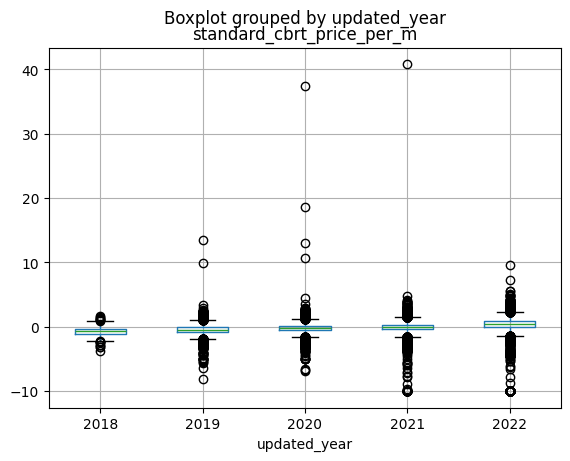

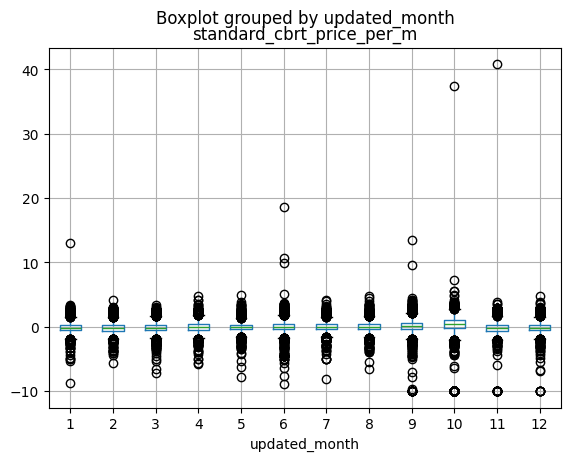

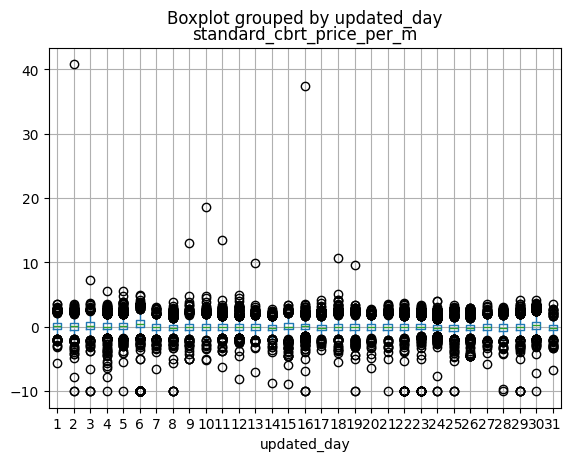

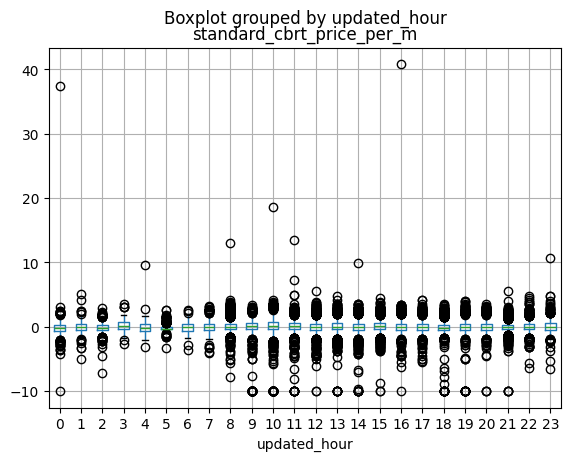

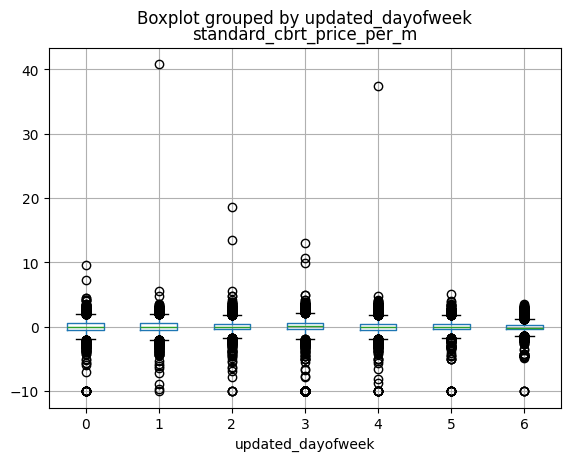

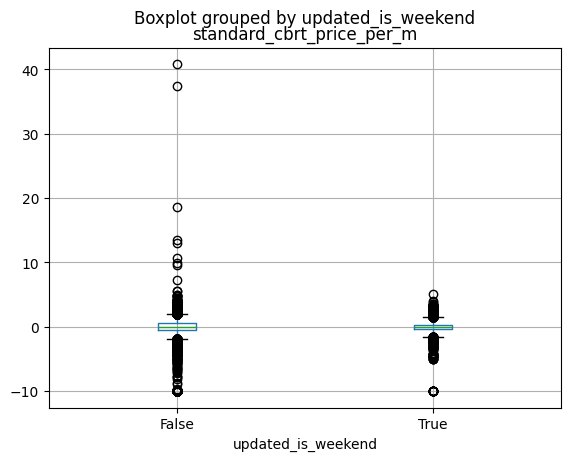

In [31]:
for column_name in ['updated_year', 'updated_month', 'updated_day', 'updated_hour', 'updated_dayofweek', 'updated_is_weekend']:
    boxplots_wrt_Y(column_name)

## Use violin plots instead
There are some outliers, which make it more difficult to visualize.
We can get rid of outliers and plot violin plots

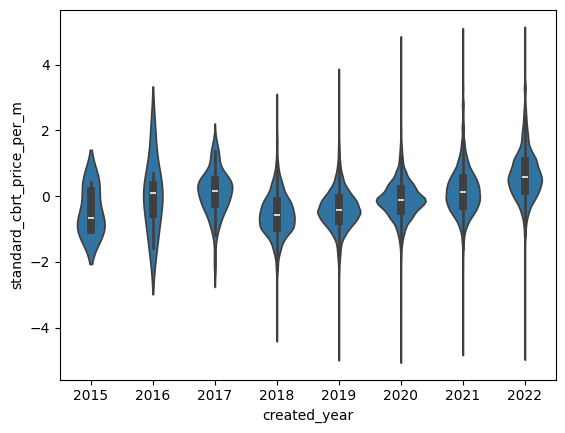

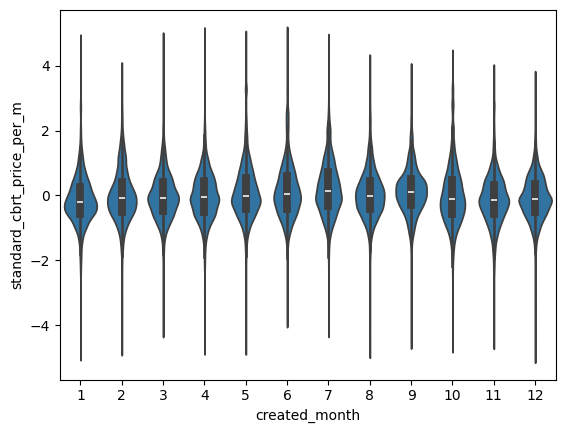

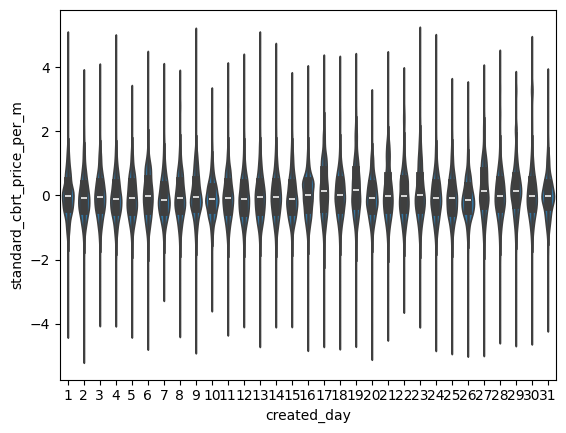

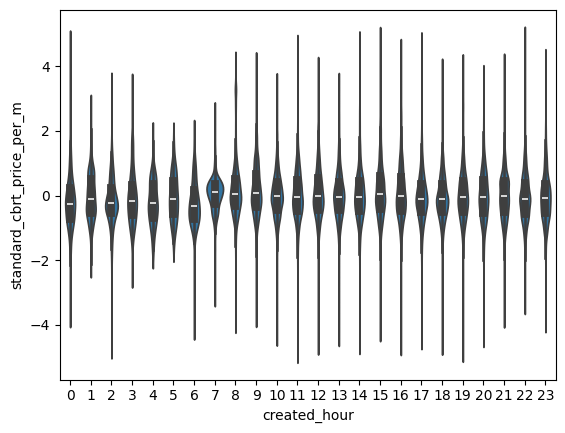

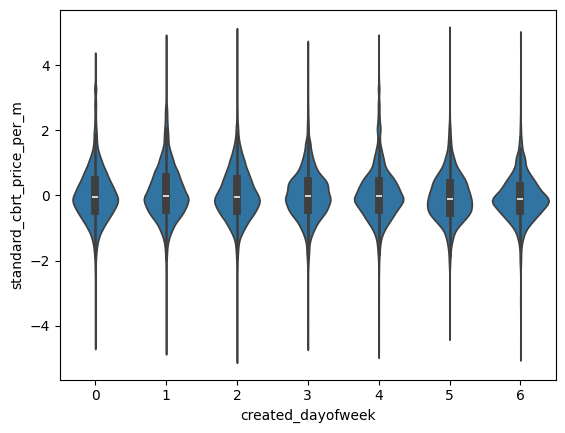

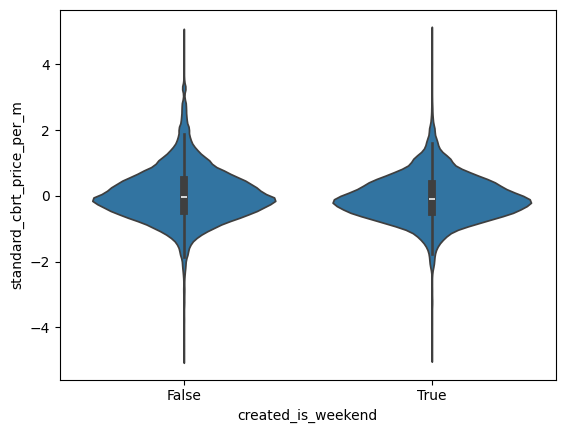

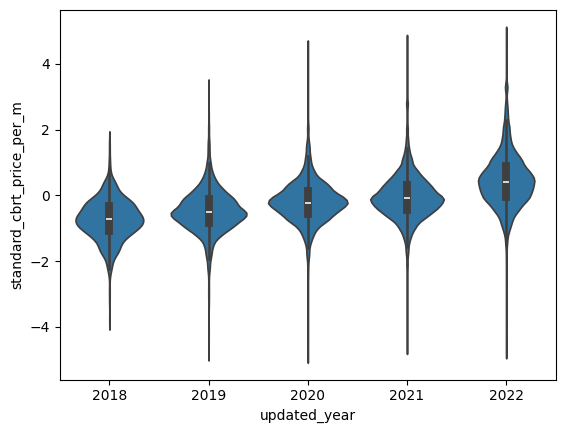

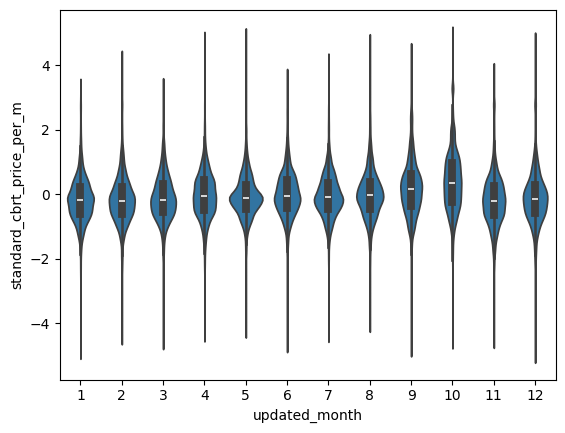

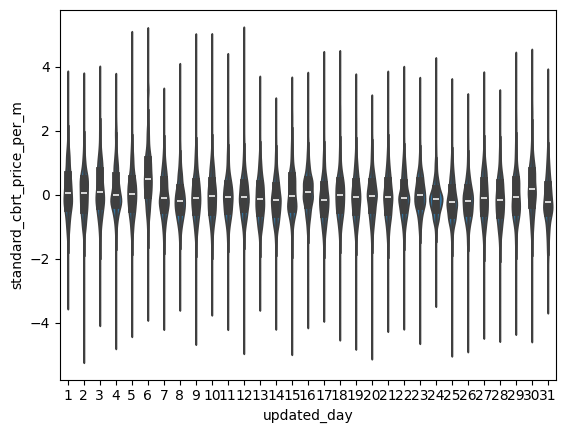

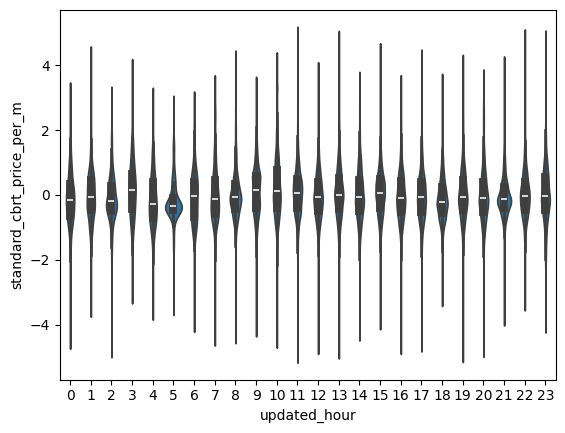

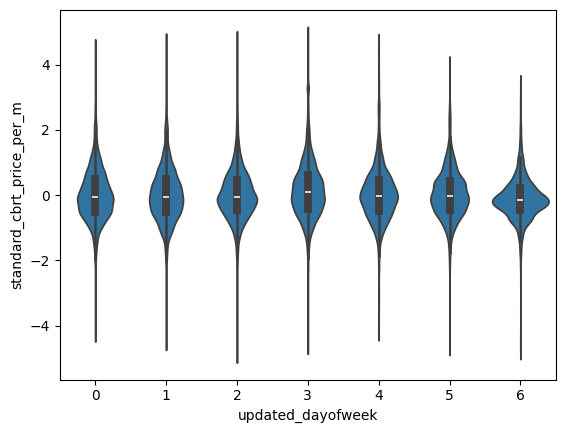

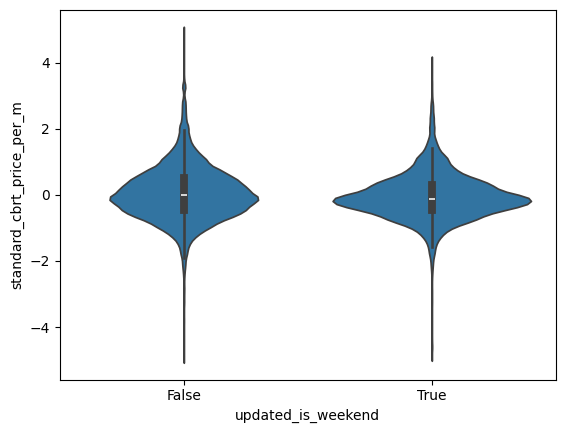

In [38]:
import seaborn as sns

tmp_df = pd.concat([df,dp.Y[np.absolute(dp.Y["standard_cbrt_price_per_m"])<5]], axis=1)
def violin_wrt_Y(column_name):
    tmp_df[column_name]
    sns.violinplot(data=tmp_df, y="standard_cbrt_price_per_m", x=column_name)
    plt.show()

for column_name in df.columns[2:]:
    violin_wrt_Y(column_name)

From the plots, we can see that:
- No single feature correlates linearly, and clearly, with the target variable, if not combined with others
- The is_weekend features may not be needed, as the dayofweek seems to encode interesting features
- The price increases with the year, which makes sense (for example for inflation)

## Cyclic transformations

Some features may benefit from cyclic transformation.

Meaning that we want some sort of "continuation" of the features (if we map Monday -> Sunday from 1 to 7, Monday seems as far apart of Sunday as possible, but indeed they are neighbors).

To do this, a possibility is to transform the data with sine and cosine transformations.

### For the created and updated hours

In [39]:
df['created_hour_sin'] = np.sin(2 * np.pi * df['created_hour'] / 24)
df['created_hour_cos'] = np.cos(2 * np.pi * df['created_hour'] / 24)
df['updated_hour_sin'] = np.sin(2 * np.pi * df['updated_hour'] / 24)
df['updated_hour_cos'] = np.cos(2 * np.pi * df['updated_hour'] / 24)

### For the created and updated day of the week

In [40]:
df['created_dayofweek_sin'] = np.sin(2 * np.pi * df['created_dayofweek'] / 7)
df['created_dayofweek_cos'] = np.cos(2 * np.pi * df['created_dayofweek'] / 7)
df['updated_dayofweek_sin'] = np.sin(2 * np.pi * df['updated_dayofweek'] / 7)
df['updated_dayofweek_cos'] = np.cos(2 * np.pi * df['updated_dayofweek'] / 7)

## Get duration features

We can also get some interesting features, such as the duration in between creation and update.

But ***WARNING***: the decision on which time features to use would depend a lot on the model and product defined, bussiness-wise.
For example, having the year as a feature would mean that, without re-training, we would have an out-of-distribution feature (the year), which could cause big errors (depending on the chosen model / architecture).

Or, choosing a feature such as "time_since_last_update", which seems very reasonable for this model, would require some re-training (imagine we use this data. for inference, the "time_since_last_update" feature would change each second it passes, unless I somehow mock it!).
So one needs to be careful with this.



In [41]:
df["duration_of_update"] = (df["updated_at"] - df["created_at_first"]).dt.total_seconds()